# Network Analysis

## Setup

In [1]:
import networkx as nx
import pandas   as pd
import igraph   as ig
import os

os.chdir(os.path.abspath(os.path.join(os.getcwd(), "..")))

## Metrics Calculations

In [2]:
from config import PATH

G = nx.DiGraph()
G = nx.read_edgelist(PATH + "real_network.csv", delimiter=",", nodetype=int, data=(('weight', float),), create_using=nx.DiGraph())

In [3]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

Number of nodes: 677640
Number of edges: 834432


In [4]:
nx.density(G)

1.8171614879550778e-06

In [5]:
in_degree              = dict(G.in_degree())
out_degree             = dict(G.out_degree())
katz_centrality        = nx.katz_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
pagerank               = nx.pagerank(G)

data = {
    'node':        list(G.nodes),
    'in_degree':   [in_degree[node] for node in G.nodes],
    'out_degree':  [out_degree[node] for node in G.nodes],
    'katz':        [katz_centrality[node] for node in G.nodes],
    'eigenvector': [eigenvector_centrality[node] for node in G.nodes],
    'pagerank':    [pagerank[node] for node in G.nodes]
}

metrics_df = pd.DataFrame(data)
metrics_df.head()

,node,in_degree,out_degree,katz,eigenvector,pagerank
0,39364684,1,206,0.001173,1.925743e-14,0.000001
1,21061006,3,0,0.001400,6.756681e-11,0.000003
2,18513522,1,0,0.001162,1.925727e-14,0.000001
3,38251731,1,0,0.001162,1.925727e-14,0.000001
4,22369434,1,0,0.001162,1.925727e-14,0.000001


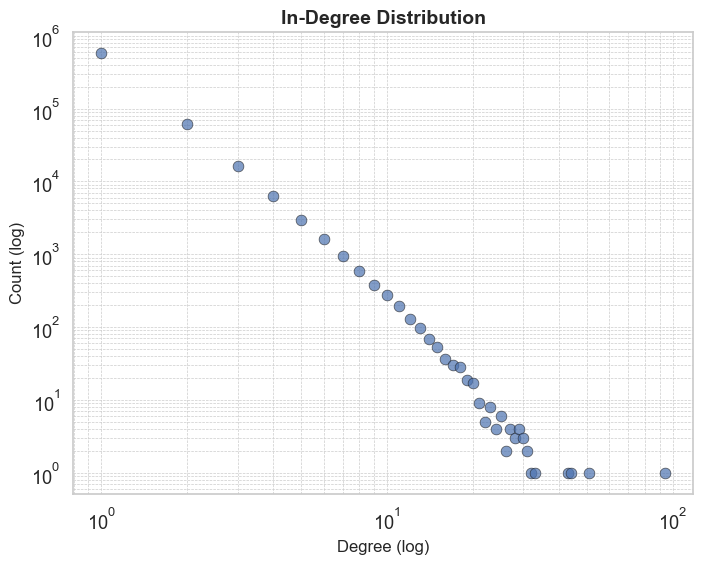

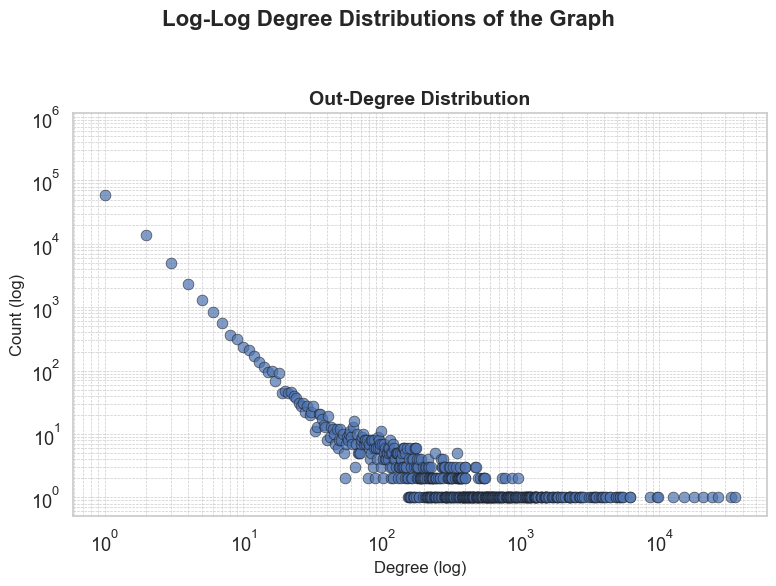

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="notebook", font_scale=1.2)

def loglog_plot(series, title):
    _, ax = plt.subplots(figsize=(8, 6))
    counts = series.value_counts().sort_index()
    ax.scatter(counts.index, counts.values, s=60, alpha=0.7, edgecolor='k', linewidth=0.5)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_xlabel("Degree (log)", fontsize=12)
    ax.set_ylabel("Count (log)", fontsize=12)
    ax.grid(True, which="both", linestyle='--', linewidth=0.5)

loglog_plot(metrics_df["in_degree"], "In-Degree Distribution")
loglog_plot(metrics_df["out_degree"], "Out-Degree Distribution")

plt.suptitle("Log-Log Degree Distributions of the Graph", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Betweeness with iGraph

Way faster than networkx.

In [6]:
df = pd.read_csv(PATH + "real_network.csv", header = None)
df.columns = ['source','target', 'weight']
df["weight"] = df["weight"].apply(lambda x: 0.0001 if x <= 0 else x)

df.head()

,source,target,weight
0,39364684,21061006,0.45
1,39364684,18513522,0.85
2,39364684,38251731,1.15
3,39364684,22369434,1.20
4,39364684,98928660,1.40


In [7]:
edge_list = list(zip(df["source"], df["target"], df["weight"]))
G = ig.Graph.TupleList(edge_list, directed=True, edge_attrs=["weight"])

In [8]:
bt = G.betweenness(directed=True, weights=G.es["weight"])
bt_df = pd.DataFrame({"node": G.vs["name"], "betweenness": bt})
bt_df.head()

,node,betweenness
0,39364684,742.0
1,21061006,0.0
2,18513522,0.0
3,38251731,0.0
4,22369434,0.0


## Metrics Dataframe

In [9]:
metrics_df = metrics_df.merge(bt_df, on="node")
metrics_df.head()

,node,in_degree,out_degree,katz,eigenvector,pagerank,betweenness
0,39364684,1,206,0.001173,1.925743e-14,0.000001,742.0
1,21061006,3,0,0.001400,6.756681e-11,0.000003,0.0
2,18513522,1,0,0.001162,1.925727e-14,0.000001,0.0
3,38251731,1,0,0.001162,1.925727e-14,0.000001,0.0
4,22369434,1,0,0.001162,1.925727e-14,0.000001,0.0


In [10]:
metrics_df.describe()

,node,in_degree,out_degree,katz,eigenvector,pagerank,betweenness
count,6.776400e+05,677640.000000,677640.000000,677640.000000,6.776400e+05,6.776400e+05,6.776400e+05
mean,1.010980e+16,1.231379,1.231379,0.001207,7.284969e-05,1.475710e-06,1.905337e+04
std,8.561247e+16,0.856394,92.302353,0.000140,1.212603e-03,8.591826e-07,1.802217e+06
min,5.700000e+01,0.000000,0.000000,0.001045,5.739166e-22,-3.712248e-04,0.000000e+00
25%,1.462378e+08,1.000000,0.000000,0.001150,1.434792e-20,1.317094e-06,0.000000e+00
50%,4.543826e+08,1.000000,0.000000,0.001163,9.628723e-15,1.317257e-06,0.000000e+00
75%,1.714993e+09,1.000000,0.000000,0.001195,1.327581e-08,1.322488e-06,0.000000e+00
max,7.884893e+17,94.000000,35379.000000,0.013551,2.493019e-01,3.751144e-04,3.755521e+08


In [11]:
metrics_df.to_csv(PATH + 'graph_metrics.csv')